In [4]:
from typing import Dict, Optional
import os
import dotenv

import mdtraj as md
import numpy as np
import pyemma
from scipy.spatial import distance
from statsmodels.tsa import stattools
import matplotlib.pyplot as plt
import lovelyplots

plt.style.use("ipynb")

from jamun.metrics._ramachandran import compute_JS_divergence_of_ramachandran, num_dihedrals
from jamun.utils import convert_to_three_letter_code

import utils as analysis_utils

/homefs/home/daigavaa/miniforge3/envs/jamun-extras/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Environment Variables

These are needed to load reference MD trajectories for comparison.

In [ ]:
JAMUN_DATA_PATH = os.environ.get("JAMUN_DATA_PATH", dotenv.get_key("../.env", "JAMUN_DATA_PATH"))
JAMUN_ROOT_PATH = os.environ.get("JAMUN_ROOT_PATH", dotenv.get_key("../.env", "JAMUN_ROOT_PATH"))
print(f"JAMUN_DATA_PATH: {JAMUN_DATA_PATH}")
print(f"JAMUN_ROOT_PATH: {JAMUN_ROOT_PATH}")

### JAMUN W&B Run Paths
Specify the Weights and Biases run paths for JAMUN sampling runs:

In [5]:
# Uncapped 2AA
wandb_sample_run_paths = [
    "prescient-design/jamun/dss1dnyt",
    "prescient-design/jamun/jls6fodw",
]

# Uncapped 4AA
# wandb_sample_run_paths = [
#     "prescient-design/jamun/xv2dsan8",
#     "prescient-design/jamun/a8fukafx",
#     "prescient-design/jamun/odb1bs62",
#     "prescient-design/jamun/5dklwb4r",
# ]

Specify which peptides to analyze:

In [16]:
filter_codes = ["AD", "CK"]
# filter_codes = None

### Load All Trajectories

In [ ]:
run_paths = [analysis_utils.get_run_path_for_wandb_run(wandb_run_path) for wandb_run_path in wandb_sample_run_paths]
JAMUN_trajs = analysis_utils.get_JAMUN_trajectories(run_paths, filter_codes=filter_codes)
JAMUN_trajs

In [ ]:
Timewarp_trajs = analysis_utils.get_Timewarp_trajectories(
    JAMUN_DATA_PATH, peptide_type="2AA", filter_codes=list(JAMUN_trajs.keys())
)
Timewarp_trajs

In [ ]:
# These are our capped datasets.
# OpenMM_trajs = analysis_utils.get_OpenMM_trajectories(JAMUN_DATA_PATH, filter_codes=list(JAMUN_trajs.keys()))
# OpenMM_trajs

In [10]:
# TBG_trajs = get_TBG_trajectories("tbg_samples")

### Ramachandran Plots

In [19]:
def plot_ramachandran_contour(traj: md.Trajectory, dihedral_index: int, ax: Optional[plt.Axes] = None) -> plt.Axes:
    """Plots the Ramachandran contour plot of a trajectory."""

    if ax is None:
        _, ax = plt.subplots(figsize=(10, 10))

    _, phi = md.compute_phi(traj)
    _, psi = md.compute_psi(traj)
    H, xedges, yedges = np.histogram2d(
        phi.T[dihedral_index], psi.T[dihedral_index], bins=np.linspace(-np.pi, np.pi, 50)
    )
    pmf = -np.log(H.T) + np.max(np.log(H.T))

    im = ax.contourf(xedges[:-1], yedges[:-1], pmf, cmap="viridis", levels=50)
    contour = ax.contour(xedges[:-1], yedges[:-1], pmf, colors="white", linestyles="solid", levels=30, linewidths=0.25)

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("$\phi$")
    ax.set_ylabel("$\psi$")

    tick_eps = 0.1
    ticks = [-np.pi + tick_eps, -np.pi / 2, 0, np.pi / 2, np.pi - tick_eps]
    tick_labels = ["$-\pi$", "$-\pi/2$", "$0$", "$\pi/2$", "$\pi$"]
    ax.set_xticks(ticks, tick_labels)
    ax.set_yticks(ticks, tick_labels)

    return ax


def get_three_letter_codes(peptide: str) -> str:
    return "-".join([convert_to_three_letter_code(aa) for aa in peptide])

In [ ]:
n_dihedrals = num_dihedrals(next(iter(JAMUN_trajs.values())))
print("n_dihedrals", n_dihedrals)
if n_dihedrals % 2 == 0:
    label_offset = 1.0
else:
    label_offset = 0.5
print("label_offset", label_offset)

fig, axs = plt.subplots(len(JAMUN_trajs), 2 * n_dihedrals, figsize=(16, 8), squeeze=False)
for i, peptide in enumerate(JAMUN_trajs):
    for j in range(n_dihedrals):
        plot_ramachandran_contour(Timewarp_trajs[peptide], j, axs[i, j])
        plot_ramachandran_contour(JAMUN_trajs[peptide], j, axs[i, j + n_dihedrals])

    # Add labels.
    axs[0, n_dihedrals // 2].text(
        label_offset,
        1.1,
        "Reference MD",
        horizontalalignment="center",
        verticalalignment="center",
        transform=axs[0, n_dihedrals // 2].transAxes,
    )
    axs[0, n_dihedrals // 2 + n_dihedrals].text(
        label_offset,
        1.1,
        "JAMUN",
        horizontalalignment="center",
        verticalalignment="center",
        transform=axs[0, n_dihedrals // 2 + n_dihedrals].transAxes,
    )
    axs[i, -1].text(
        1.1,
        0.5,
        get_three_letter_codes(peptide),
        rotation=90,
        verticalalignment="center",
        horizontalalignment="center",
        transform=axs[i, -1].transAxes,
    )

plt.tight_layout()
plt.show()

### Feature Histograms

In [ ]:
fig, axs = plt.subplots(nrows=len(JAMUN_trajs), ncols=2, figsize=(12, 6), squeeze=False)
for i, peptide in enumerate(JAMUN_trajs):
    Timewarp_feat, Timewarp_featurized_traj = analysis_utils.get_pyEMMA_featurized_trajectory(Timewarp_trajs[peptide])
    pyemma.plots.plot_feature_histograms(
        Timewarp_featurized_traj, feature_labels=Timewarp_feat.describe(), ax=axs[i, 0]
    )

    JAMUN_feat, JAMUN_featurized_traj = analysis_utils.get_pyEMMA_featurized_trajectory(JAMUN_trajs[peptide])
    pyemma.plots.plot_feature_histograms(JAMUN_featurized_traj, feature_labels=JAMUN_feat.describe(), ax=axs[i, 1])

    axs[i, -1].text(
        1.1,
        0.5,
        get_three_letter_codes(peptide),
        rotation=90,
        verticalalignment="center",
        horizontalalignment="center",
        transform=axs[i, -1].transAxes,
    )

axs[0, 0].set_title("Reference MD")
axs[0, 1].set_title("JAMUN")
plt.tight_layout()

In [ ]:
for i, peptide in enumerate(JAMUN_trajs):
    print("peptide", peptide)

    Timewarp_feat, Timewarp_featurized_traj = analysis_utils.get_pyEMMA_featurized_trajectory(Timewarp_trajs[peptide])
    JAMUN_feat, JAMUN_featurized_traj = analysis_utils.get_pyEMMA_featurized_trajectory(JAMUN_trajs[peptide])

    for j, feat in enumerate(Timewarp_feat.describe()):
        Timewarp_p = np.histogram(Timewarp_featurized_traj[:, j], range=(-np.pi, np.pi), bins=100)[0]
        JAMUN_p = np.histogram(JAMUN_featurized_traj[:, j], range=(-np.pi, np.pi), bins=100)[0]
        print(feat, "JSD:", distance.jensenshannon(Timewarp_p, JAMUN_p))

### TICA Analysis

In [ ]:
def compute_TICA_stats(traj_tica: np.ndarray, ref_tica: np.ndarray) -> Dict[str, float]:
    """Compute stats on TICA projections of trajectories."""
    tica_0_min = min(ref_tica[:, 0].min(), traj_tica[:, 0].min())
    tica_0_max = max(ref_tica[:, 0].max(), traj_tica[:, 0].max())

    tica_1_min = min(ref_tica[:, 1].min(), traj_tica[:, 1].min())
    tica_1_max = max(ref_tica[:, 1].max(), traj_tica[:, 1].max())

    ref_p = np.histogram(ref_tica[:, 0], range=(tica_0_min, tica_0_max), bins=100)[0]
    traj_p = np.histogram(traj_tica[:, 0], range=(tica_0_min, tica_0_max), bins=100)[0]
    tica_0_jsd = distance.jensenshannon(ref_p, traj_p)

    ref_p = np.histogram2d(*ref_tica[:, :2].T, range=((tica_0_min, tica_0_max), (tica_1_min, tica_1_max)), bins=50)[0]
    traj_p = np.histogram2d(*traj_tica[:, :2].T, range=((tica_0_min, tica_0_max), (tica_1_min, tica_1_max)), bins=50)[0]
    tica_01_jsd = distance.jensenshannon(ref_p.flatten(), traj_p.flatten())

    return {
        "TICA-0 JSD": tica_0_jsd,
        "TICA-0,1 JSD": tica_01_jsd,
    }

In [27]:
fig, axs = plt.subplots(nrows=len(JAMUN_trajs), ncols=2, figsize=(12, 6), squeeze=False)

for i, peptide in enumerate(JAMUN_trajs):
    print("peptide", peptide)

    Timewarp_feat, Timewarp_featurized_traj = analysis_utils.get_pyEMMA_featurized_trajectory(
        Timewarp_trajs[peptide], cossin=True
    )
    JAMUN_feat, JAMUN_featurized_traj = analysis_utils.get_pyEMMA_featurized_trajectory(
        JAMUN_trajs[peptide], cossin=True
    )

    tica = pyemma.coordinates.tica(Timewarp_featurized_traj, lag=1000, kinetic_map=True)
    Timewarp_tica = tica.transform(Timewarp_featurized_traj)
    JAMUN_tica = tica.transform(JAMUN_featurized_traj)

    # Compute stats.
    tica_stats = compute_TICA_stats(JAMUN_tica, Timewarp_tica)
    print(tica_stats["TICA-0 JSD"])
    print(tica_stats["TICA-0,1 JSD"])

    # Plot free energy.
    pyemma.plots.plot_free_energy(Timewarp_tica[:, 0], Timewarp_tica[:, 1], cmap="plasma", ax=axs[i, 0])
    axs[i, 0].set_title("Reference MD")

    pyemma.plots.plot_free_energy(JAMUN_tica[:, 0], JAMUN_tica[:, 1], cmap="plasma", ax=axs[i, 1])
    axs[i, 1].set_title("JAMUN")

    axs[i, -1].text(
        1.4,
        0.5,
        get_three_letter_codes(peptide),
        rotation=90,
        verticalalignment="center",
        horizontalalignment="center",
        transform=axs[i, -1].transAxes,
    )

plt.tight_layout()

peptide AD


/homefs/home/daigavaa/miniforge3/envs/jamun-extras/lib/python3.10/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())
/homefs/home/daigavaa/miniforge3/envs/jamun-extras/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /homefs/home/daigavaa/miniforge3/envs/jamun-extras/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


NameError: name 'stattools' is not defined

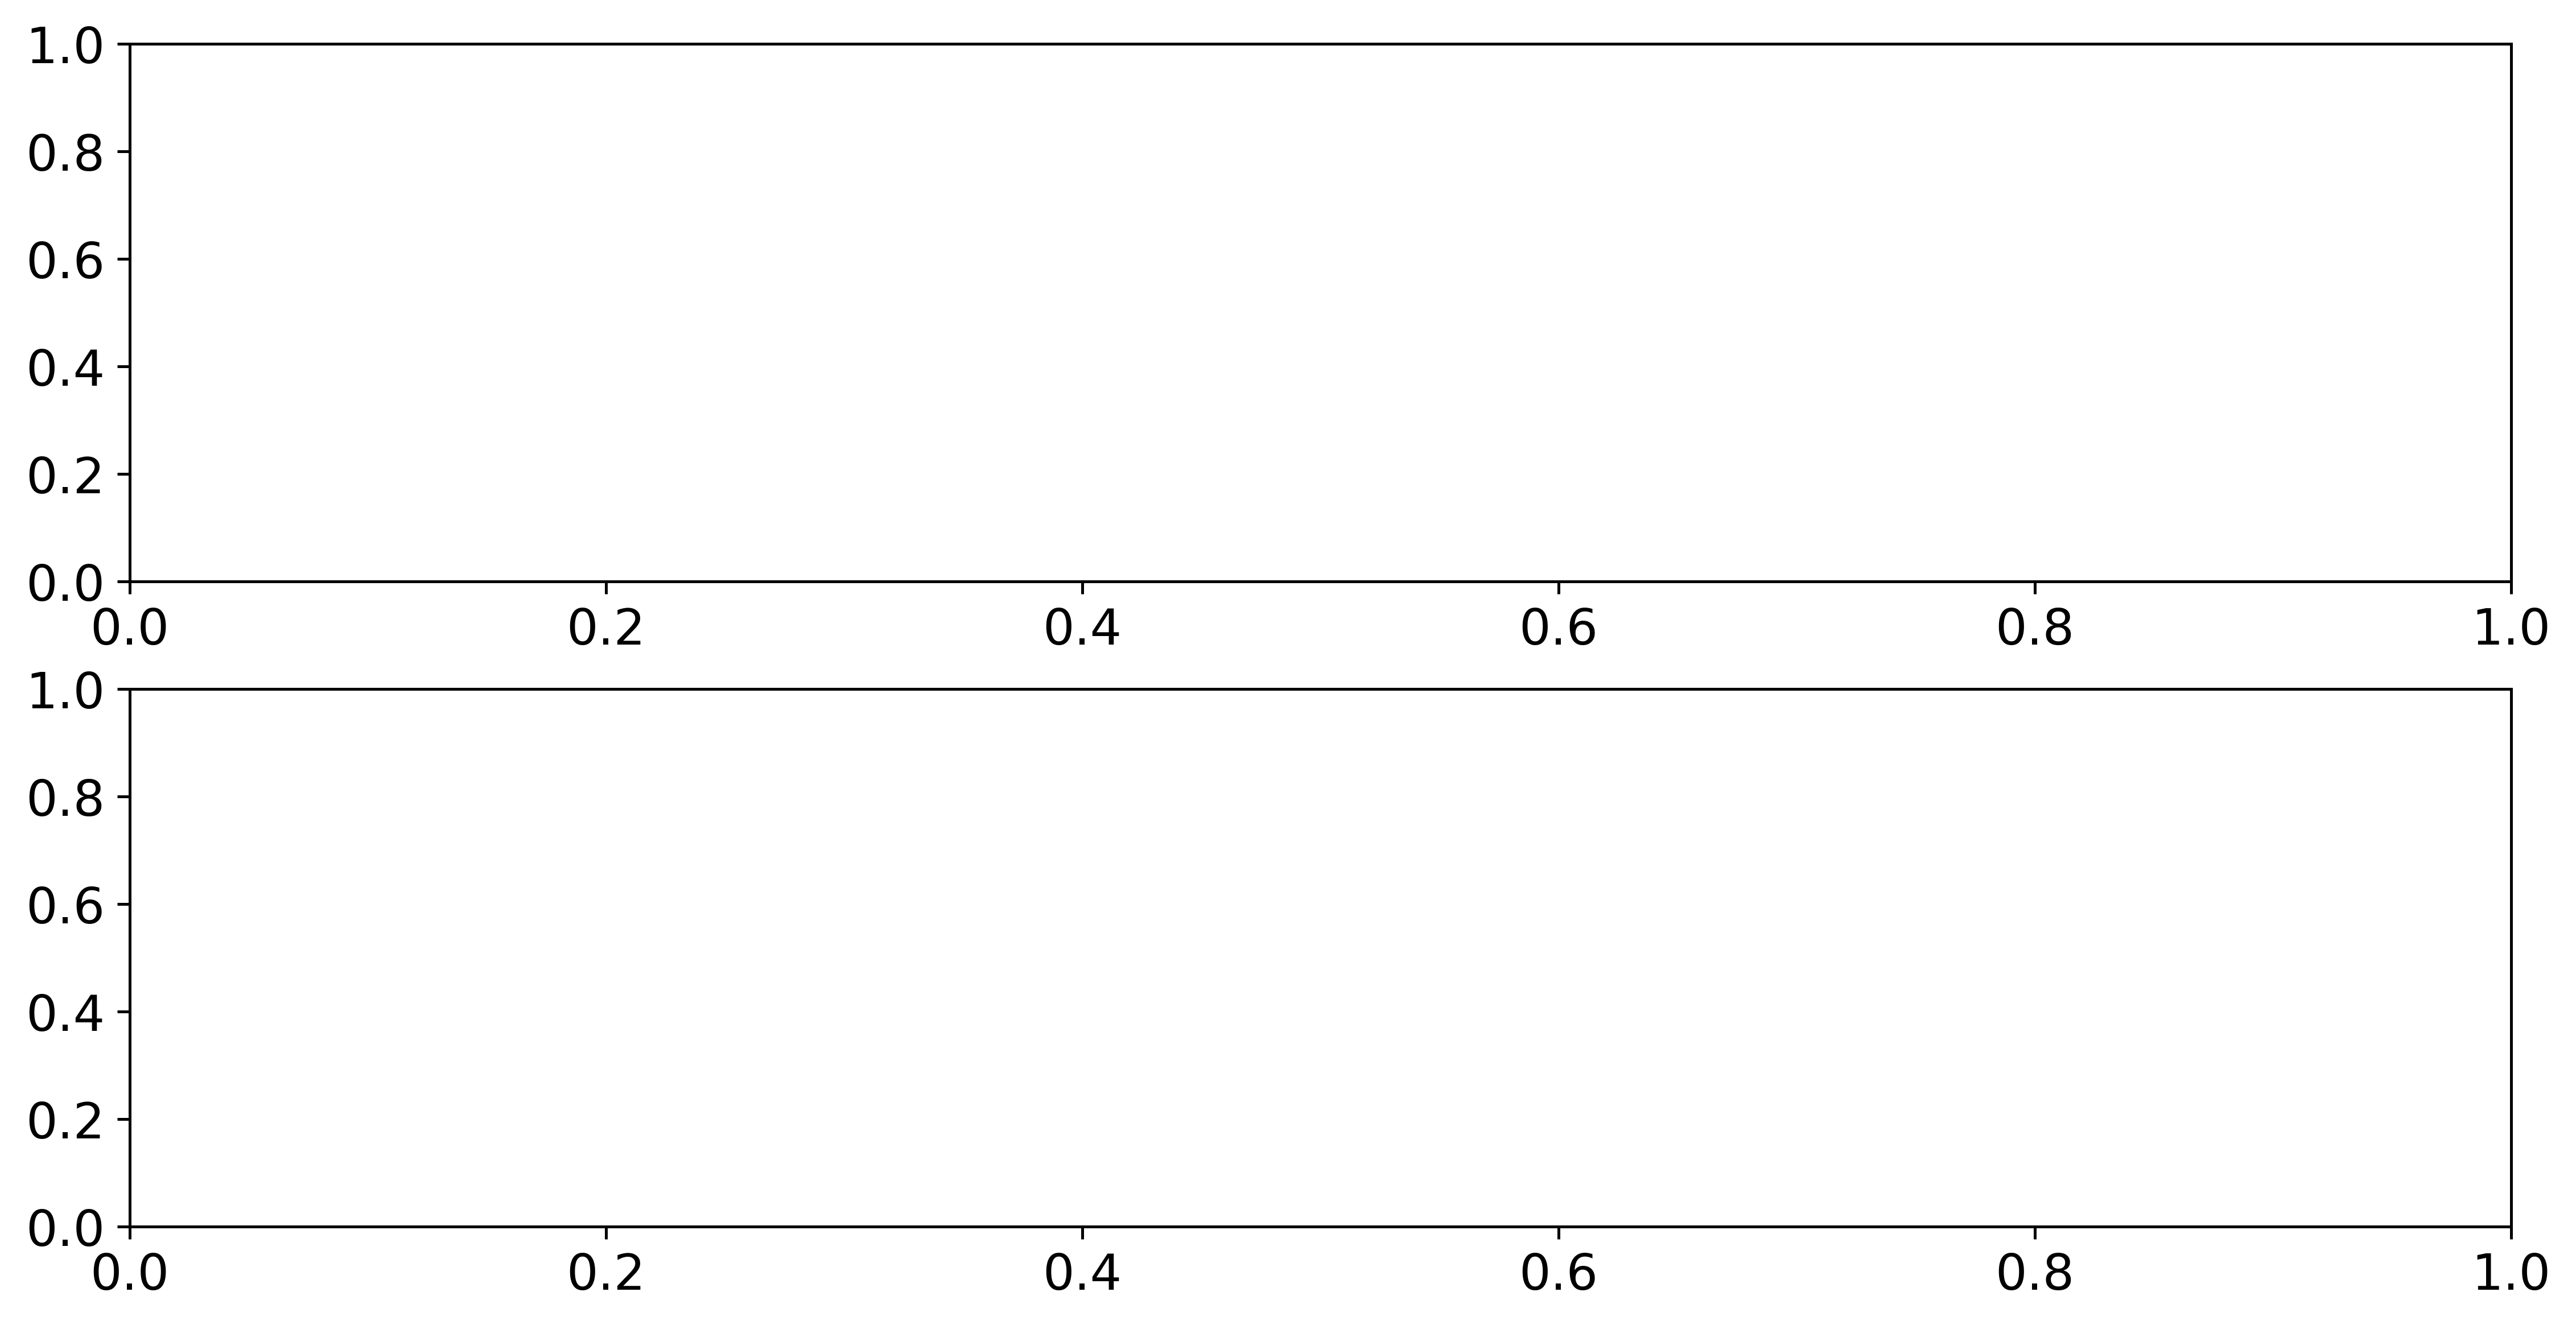

In [28]:
fig, axs = plt.subplots(nrows=len(JAMUN_trajs), ncols=1, figsize=(12, 6), squeeze=False)

for i, peptide in enumerate(JAMUN_trajs):
    print("peptide", peptide)

    Timewarp_feat, Timewarp_featurized_traj = analysis_utils.get_pyEMMA_featurized_trajectory(
        Timewarp_trajs[peptide], cossin=True
    )
    JAMUN_feat, JAMUN_featurized_traj = analysis_utils.get_pyEMMA_featurized_trajectory(
        JAMUN_trajs[peptide], cossin=True
    )

    tica = pyemma.coordinates.tica(Timewarp_featurized_traj, lag=1000, kinetic_map=True)
    Timewarp_tica = tica.transform(Timewarp_featurized_traj)
    JAMUN_tica = tica.transform(JAMUN_featurized_traj)

    nlag = 1000
    Timewarp_autocorr = stattools.acovf(Timewarp_tica[:, 0], nlag=nlag, adjusted=True, demean=False)
    JAMUN_autocorr = stattools.acovf(JAMUN_tica[:, 0], nlag=nlag, adjusted=True, demean=False)

    axs[i].plot(Timewarp_autocorr, label="Reference MD")
    axs[i].plot(JAMUN_autocorr, label="JAMUN")
    axs[i].title(f"TICA-0 Autocorrelation")
    axs[i].xlabel("Lag")
    axs[i].ylabel("Autocorrelation")
    axs[i].legend()

plt.show()

In [16]:
def compute_JS_divergence_vs_time(traj: md.Trajectory, reference_traj: md.Trajectory, t_steps: int) -> np.ndarray:
    """Computes the JS divergence between the Ramachandran distributions of a trajectory and a reference trajectory at different time points."""
    steps = np.linspace(0, len(traj), (t_steps + 1)).astype(int)[1:]

    js_divs = [
        compute_JS_divergence_of_ramachandran(
            traj[:step],
            reference_traj,
        )
        for step in steps
    ]
    return np.array(js_divs)


def compute_JS_divergences_vs_time(
    trajs: Dict[str, md.Trajectory], reference_trajs: Dict[str, md.Trajectory], t_steps: int
) -> Dict[str, np.ndarray]:
    """Computes the JS divergence between the Ramachandran distributions of a set of trajectories and a reference trajectory at different time points."""
    return {
        peptide: compute_JS_divergence_vs_time(trajs[peptide], reference_trajs[peptide], t_steps) for peptide in trajs
    }

In [17]:
t_steps = 10
JAMUN_js_divs = compute_JS_divergences_vs_time(JAMUN_trajs, Timewarp_trajs, t_steps)
Timewarp_js_divs = compute_JS_divergences_vs_time(Timewarp_trajs, Timewarp_trajs, t_steps)

In [ ]:
for index, peptide in enumerate(JAMUN_js_divs):
    if index == 0:
        Timewarp_label = None
        JAMUN_label = None
    else:
        Timewarp_label = "Reference MD"
        JAMUN_label = "JAMUN"

    progress = np.arange(t_steps) / t_steps
    plt.plot(progress, Timewarp_js_divs[peptide], color="C0", label=Timewarp_label)
    plt.plot(progress, JAMUN_js_divs[peptide], color="C1", label=JAMUN_label)

plt.title("Jenson-Shannon Divergences")
plt.xlabel("Fraction of Trajectory Progress", fontsize=12)
plt.ylabel("Jenson-Shannon Divergence", fontsize=12)
plt.ticklabel_format(useOffset=False, style="plain")
plt.legend(fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()